In [7]:
%matplotlib inline
import urllib
import os
import zipfile
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
from sklearn import linear_model
from sklearn import tree
from sklearn.cross_validation import train_test_split

from __future__ import division

In [8]:
df = pd.DataFrame.from_csv("df_cleaned_up.csv")
df.issue_d = pd.to_datetime(df.issue_d)

/Users/Branko/miniconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2809: DtypeWarning: Columns (48) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Loan count grew drastically in the later years while the loan size grew slightly


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,...,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,credit_history,total_return,num_payments_made,average_payment,annual_return
count,8.796600e+04,8.796600e+04,87966.000000,87966.000000,87966.000000,87966.000000,87966.000000,87966.000000,87966.000000,8.796600e+04,...,87927.000000,3.243100e+04,4.894500e+04,48945.000000,32431.000000,87966.000000,87966.000000,87966.000000,87966.000000,87966.000000
mean,1.407977e+06,1.698311e+06,11326.934838,11247.610440,11016.843764,37.081782,12.224993,370.974650,5.276300,6.820471e+04,...,0.002889,1.506812e+05,3.897843e+04,19138.421596,31723.461102,170.468374,0.090899,26.685117,674.831499,0.062952
std,8.362347e+05,1.016303e+06,7033.543545,6984.917652,7004.614888,4.979236,3.684407,237.734457,3.517202,6.490925e+04,...,0.079181,1.678793e+05,3.709157e+04,18322.084316,34723.123186,82.704852,0.245773,11.627563,1278.787740,0.269668
min,5.473400e+04,7.069900e+04,500.000000,500.000000,0.000000,36.000000,5.420000,15.690000,0.000000,4.000000e+03,...,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,36.000000,-0.995061,1.000000,15.271081,-1.000000
25%,7.233645e+05,9.177962e+05,6000.000000,6000.000000,6000.000000,36.000000,8.900000,196.220000,2.000000,4.066800e+04,...,NaN,NaN,NaN,NaN,NaN,114.000000,0.091043,18.000000,239.549444,0.087535
50%,1.279286e+06,1.522142e+06,10000.000000,10000.000000,9975.000000,36.000000,12.120000,326.160000,5.000000,5.800000e+04,...,NaN,NaN,NaN,NaN,NaN,155.000000,0.149494,30.000000,404.598529,0.132459
75%,1.616141e+06,1.887878e+06,15000.000000,15000.000000,14850.000000,36.000000,14.650000,486.970000,10.000000,8.200000e+04,...,NaN,NaN,NaN,NaN,NaN,211.000000,0.214095,36.000000,693.089173,0.176047
max,3.537155e+06,4.429645e+06,35000.000000,35000.000000,35000.000000,60.000000,24.890000,1388.450000,10.000000,7.141778e+06,...,7.000000,8.592561e+06,1.924200e+06,522210.000000,902504.000000,785.000000,0.644860,70.000000,35682.130000,0.477894


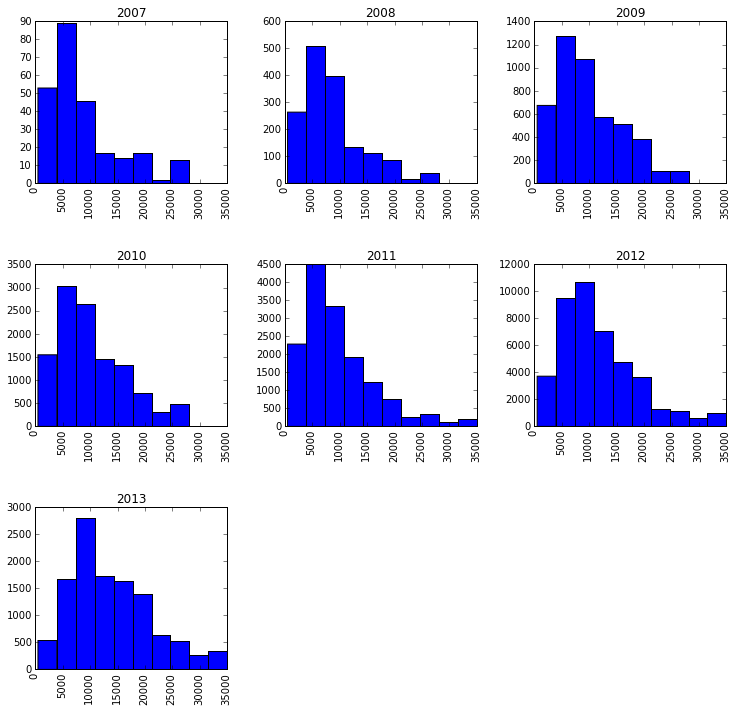

In [40]:
# Let's take a look at the data
print "Loan count grew drastically in the later years while the loan size grew slightly"
df.funded_amnt.hist(by=df.issue_d.dt.year, range=(df.funded_amnt.min(), df.funded_amnt.max()), figsize=(12,12))
df.describe()

14.59% of loans are taking some sort of charge off 
7.60% of principal is not being repaid 
Of those taking some kind of charge-off, the severity is 50.93%


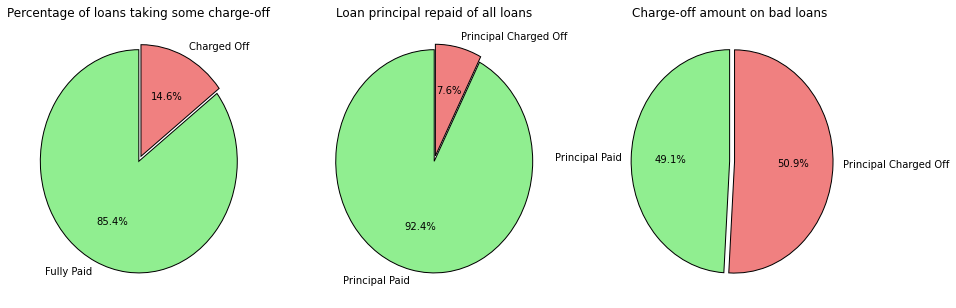

In [64]:
# Since we'll be looking at predicting loan performance, we'll limit the data set to only matured loans

# First pie
fig, axes = plt.subplots(1,3,figsize=(15,5))

labels = 'Fully Paid', 'Charged Off'
fracs = [len(df_fully_paid), 
         len(df_charged_off)]

explode=(0, 0.05)

axes[0].pie(fracs, explode=explode, labels=labels,
                autopct='%1.1f%%', colors = ['lightgreen','lightcoral'], startangle=90)

axes[0].set_title('Percentage of loans taking some charge-off')

print "%.2f%% of loans are taking some sort of charge off " % (len(df_charged_off) / len(df) * 100)

# Second pie
# ax = fig.add_subplot(222)

principal_paid = sum(df.total_rec_prncp)
principal_charged_off = sum(df.funded_amnt) - principal_paid

labels = 'Principal Paid', 'Principal Charged Off'
fracs = [principal_paid, 
         principal_charged_off]

axes[1].pie(fracs, explode=explode, labels=labels,
                autopct='%1.1f%%', colors = ['lightgreen','lightcoral'], startangle=90)

axes[1].set_title('Loan principal repaid of all loans')

print "%.2f%% of principal is not being repaid " % \
                        (principal_charged_off / (principal_paid + principal_charged_off) * 100)

# # Third pie

principal_paid = sum(df_charged_off.total_rec_prncp) 
principal_charged_off = sum(df_charged_off.funded_amnt) - principal_paid

labels = 'Principal Paid', 'Principal Charged Off'
fracs = [principal_paid, 
         principal_charged_off]

axes[2].pie(fracs, explode=explode, labels=labels,
                autopct='%1.1f%%', colors = ['lightgreen','lightcoral'], startangle=90)

axes[2].set_title('Charge-off amount on bad loans')

print "Of those taking some kind of charge-off, the severity is %.2f%%" % \
                         (principal_charged_off / (principal_charged_off + principal_paid) * 100)

In [10]:
def stacked_bar_chart(stacks, title="", 
                      labels=None,     
                      colors = ['lightgreen','lightcoral', 'lightgoldenrodyellow','lavender','lightcyan']):
    """ Display pretty stacked bar chart
        
        Parameters
        ----------
        stacks: array-like
            list of values for the chart
        labels: array-like
            list of labels for the chart
        
        Returns
        ----------
        self: None
        """
    if labels is None:
        labels = ['' for i in range(len(stacks))]

    # plot
    fig, ax = plt.subplots(figsize=(18, 6))
    width = 0.8; 
    xlocations=np.array(range(len(stacks[0])+2))
    adjlocs = xlocations[1:-1] - width/2.0
    
    bar_heights = np.zeros(len(stacks[0]))
    for num in range(len(stacks)):
        bars = ax.bar(adjlocs, stacks[num], width, 
         label=labels[num], color=colors[num % len(colors)],
         bottom=sum(stacks[:num]))
        
        stack_labels = ["%.2f%% " % (val * 100) for val in stacks[num].tolist()]
        
        for rect, label, height in zip(bars.patches, stack_labels, bar_heights):
            ax.text(rect.get_x() + rect.get_width()/2, height, 
                    label, color='black', ha='center', va='bottom')
        bar_heights += np.array([bar.get_height() for bar in bars.patches])
        

    # pretty-up
    if max(map(lambda x: len(str(x)), stacks[0].index)) > 4:
        # rotate x label if large
        xrotation = 45
    else:
        xrotation = 0
        
    ax.set_xticks(ticks=xlocations[1:-1])
    ax.set_xticklabels(stacks[0].index, rotation=xrotation)
    ax.yaxis.grid(True)
    ax.legend(loc='best', prop={'size':'small'})
    fig.suptitle(title)
    fig.tight_layout(pad=2)
    


Severity averages at 46%


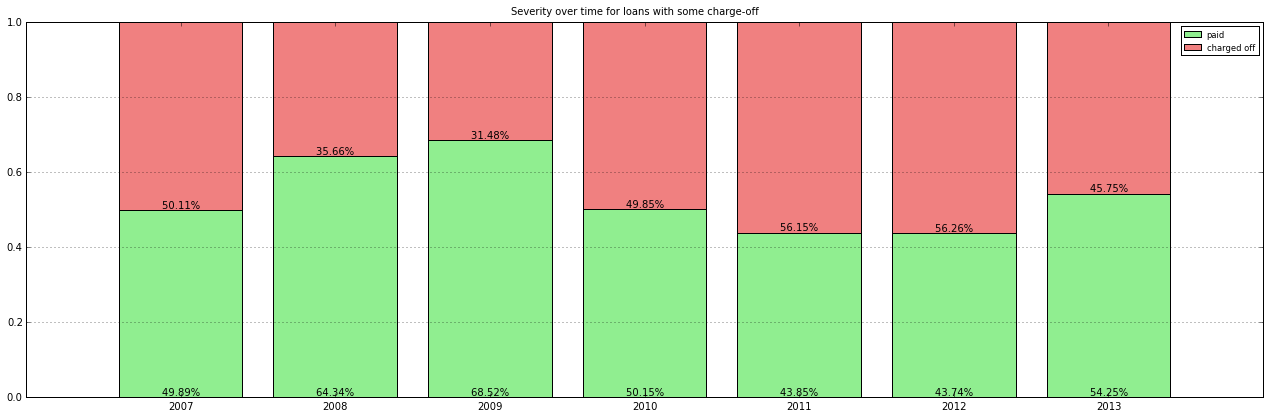

In [11]:
# Let's look at loan severity for those loans taking some kind of charge-off

charged_off_paid = df_charged_off.groupby(df_charged_off.issue_d.dt.year).total_rec_prncp.sum()
charged_off_funded = df_charged_off.groupby(df_charged_off.issue_d.dt.year).funded_amnt.sum()
paid = (charged_off_paid / charged_off_funded)
charged_off = 1 - paid

stacked_bar_chart([paid, charged_off], labels=['paid', 'charged off'],
                  title="Severity over time for loans with some charge-off")

print "Severity averages at %d%%" % (np.mean(charged_off) * 100)



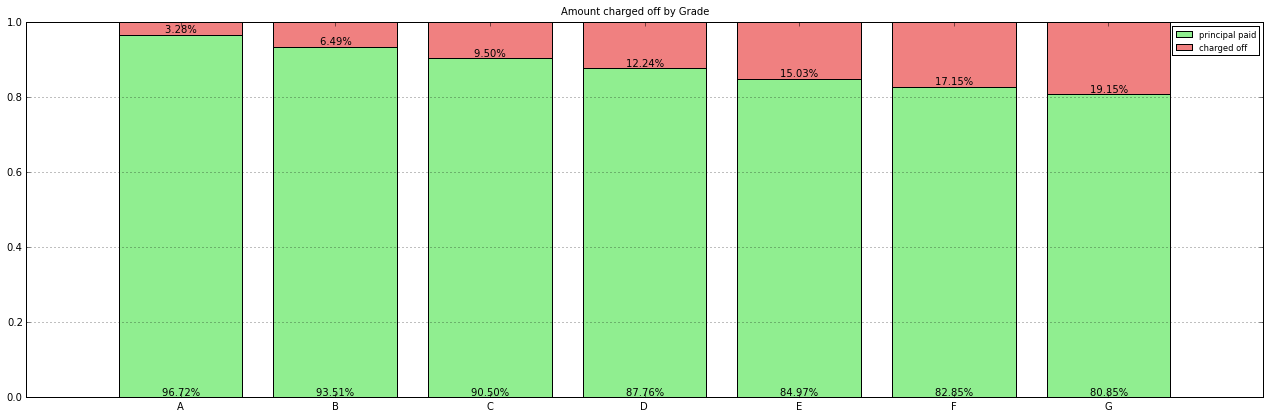

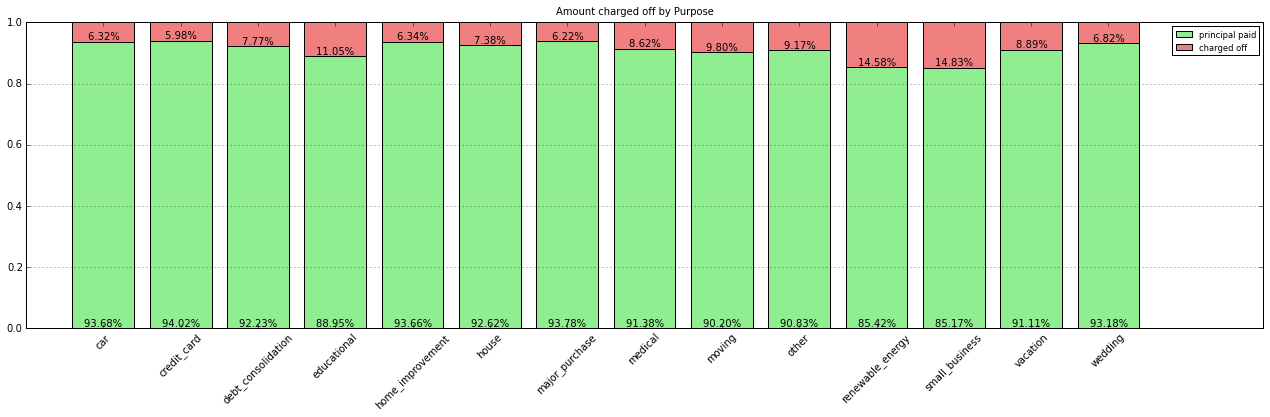

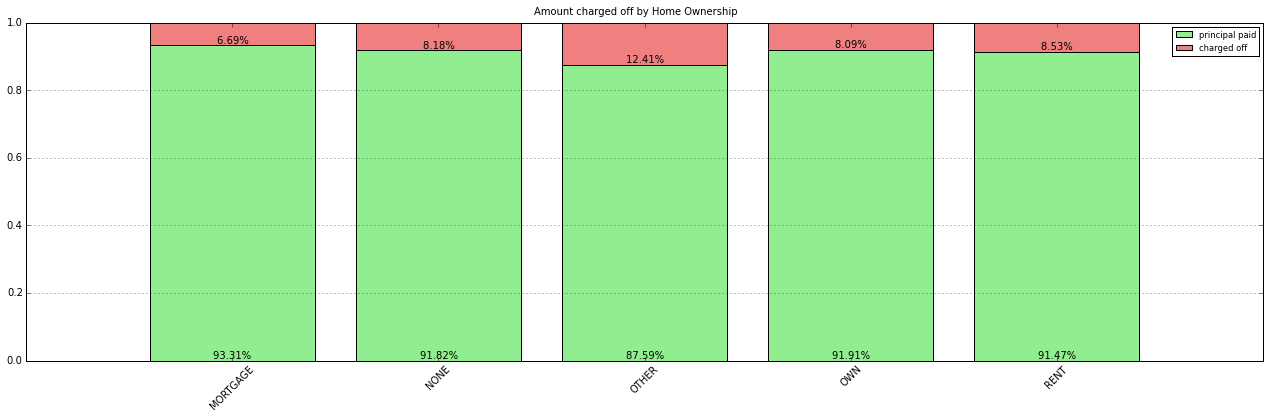

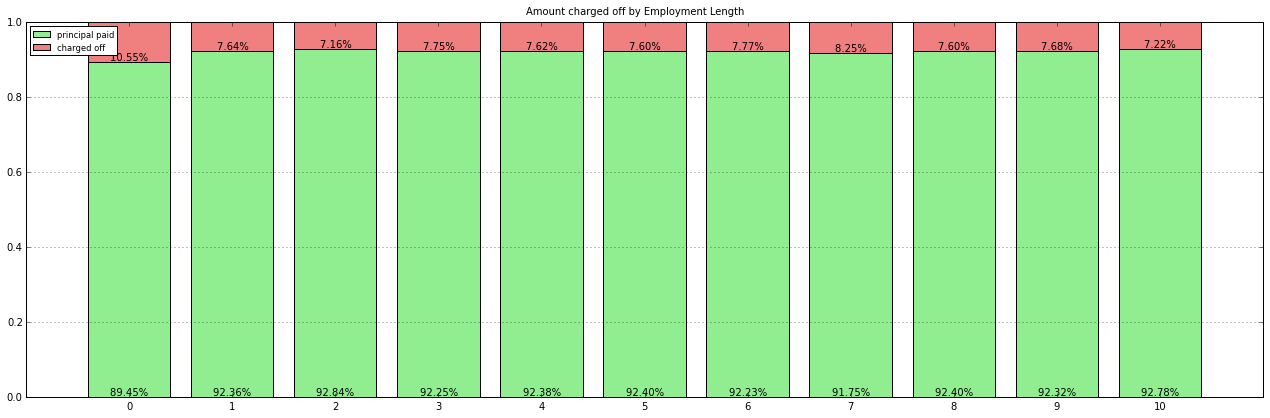

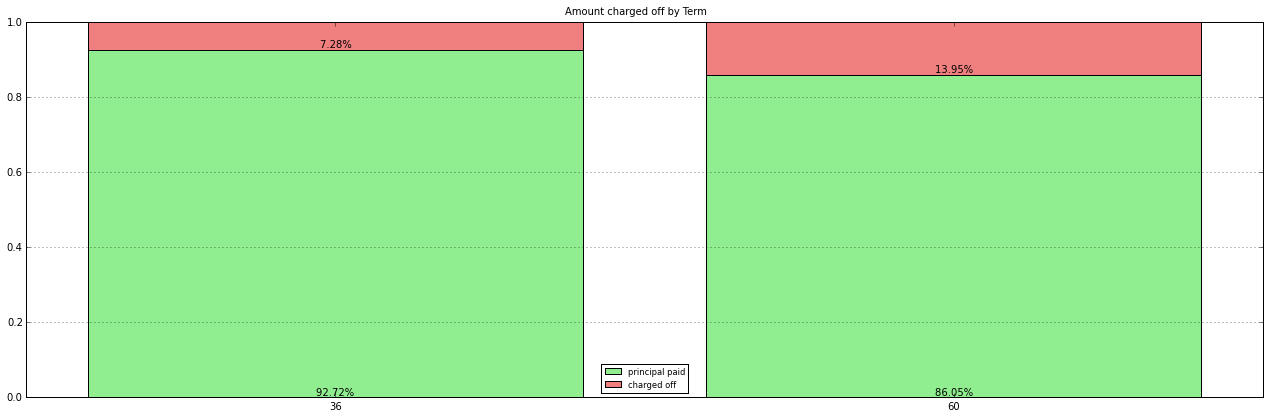

In [12]:
# Charge-offs based on type of loan

categorical_features = [df.grade, df.purpose, df.home_ownership, 
                        df.emp_length, df.term]
categorical_features_labels = ['Grade', 'Purpose', 'Home Ownership', "Employment Length", "Term"]

for feature, label in zip(categorical_features, categorical_features_labels):
    funded = df.groupby(feature).funded_amnt.sum()
    principal_paid = df.groupby(feature).total_rec_prncp.sum()
    interest_paid = df.groupby(feature).total_rec_int.sum()
    charged_off = funded - principal_paid

    principal_paid /= funded
    interest_paid /= funded
    charged_off /= funded

    stacked_bar_chart([principal_paid, charged_off], labels=['principal paid', 'charged off'],
                    title="Amount charged off by %s" % label)



In [14]:
df[['total_return','annual_return']].groupby([df.term,df.grade]).aggregate([np.mean, len])

total_return          annual_return         
                   mean      len          mean      len
term grade                                             
36   A         0.064402  22287.0      0.050210  22287.0
     B         0.092676  31126.0      0.068903  31126.0
     C         0.098021  18551.0      0.069233  18551.0
     D         0.106112   9735.0      0.069961   9735.0
     E         0.114698   1880.0      0.071129   1880.0
     F         0.098620    342.0      0.054135    342.0
     G         0.060875     80.0      0.013726     80.0
60   A         0.103020    279.0      0.044090    279.0
     B         0.111460   1070.0      0.031101   1070.0
     C         0.126565    817.0      0.015910    817.0
     D         0.168396    747.0      0.052536    747.0
     E         0.166323    693.0      0.041283    693.0
     F         0.211851    255.0      0.081807    255.0
     G         0.230359    104.0      0.075821    104.0

### Returns by group

Note that returns look in line with historical returns provided by Lending Club* although  our calculated returns are lower than that provided by Lending Club. This is likely because Lending Club reports Net Annualized Return which includes an estimate of future losses based off historical charge off rates by loan grade and loan status over a 9-month period. Our model just looks at matured loans. Even though the annual returns are different that those reported by Lending Club, the relative return amounts are the same with E loans giving the highest returns.

* https://www.lendingclub.com/info/demand-and-credit-profile.action